## Кластеризация песен пользователя

Была попытка построить рекомендательную систему по эмбедингам, но точность оказалась крайне маленькой. На хабре в статье от ВК нашла информацию, что лучше сначала проводить кластеризацию данных, делать по жанрам (что в целом логично :D ) https://habr.com/ru/companies/vk/articles/683152/ 

In [4]:
# пример использования
estimate_parquet_ram_usage("filtered_embeddings.parquet")


📁 Файл: filtered_embeddings.parquet
📊 Сэмпл строк: 10,000
🔹 Размер sample: 117.38 MB
🔹 Всего строк в файле: 847,921

📐 Примерная оценка объёма данных в памяти: 9.72 GB


In [1]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 17.9 MB/s  0:00:00 5.7 MB/s eta 0:00:01


In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import umap
import hdbscan
import polars as pl

import numpy as np
from umap.umap_ import UMAP



embd = pl.scan_parquet("filtered_embeddings.parquet") #.filter(pl.col("item_id").is_in(all_items))
items_meta = pl.scan_parquet("../data/items_meta.parquet")

df_merged = embd.join(
    items_meta.select(["item_id", "artist_id", "album_id"]),
    on="item_id",
    how="left",
)

artist_meta = (
    pl.scan_parquet("../data/items_meta.parquet")
    .select(["artist_id", "item_id"])
    .unique()
    .group_by("artist_id")
    .agg(pl.col("item_id").alias("items"))
    .collect()

)

/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
artist_meta

artist_id,items
f64,list[u32]
1.08943e6,"[6619127, 2091564]"
890911.0,[5016519]
455924.0,[4952650]
177767.0,[9116714]
395315.0,[2922222]
…,…
251759.0,"[9299371, 4539526, … 1563061]"
402170.0,[2031698]
584631.0,[3371610]


In [62]:
# target_items = [item for sublist in artist_meta["items"][:1000] for item in sublist]
# target_items = [item for sublist in artist_meta["items"][:1000] for item in sublist]
target_items = [item for sublist in artist_meta.filter(pl.col("artist_id").is_in([51490.0, 40283.0]))["items"] for item in sublist]


current_emb = df_merged.filter(pl.col("item_id").is_in(target_items)).collect()


embeddings = current_emb["normalized_embed"].to_list()
embeddings = np.array(embeddings, dtype="float32")

artist = current_emb["artist_id"].to_list()


np.random.seed(42)



In [63]:

# Снижение размерности для визуализации
# pca = PCA(n_components=20)
# embeddings_2d = pca.fit_transform(embeddings)


# --- UMAP ---
umap_model = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
)

embeddings_2d = umap_model.fit_transform(embeddings)


/opt/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [64]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)


# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=30,
#     min_samples=10,
#     metric='euclidean',  # или 'euclidean', зависит от эмбеддингов
#     cluster_selection_method='eom'
# )

# labels = clusterer.fit_predict(embeddings)  # кластеризация на исходных данных

In [17]:
# unique_labels

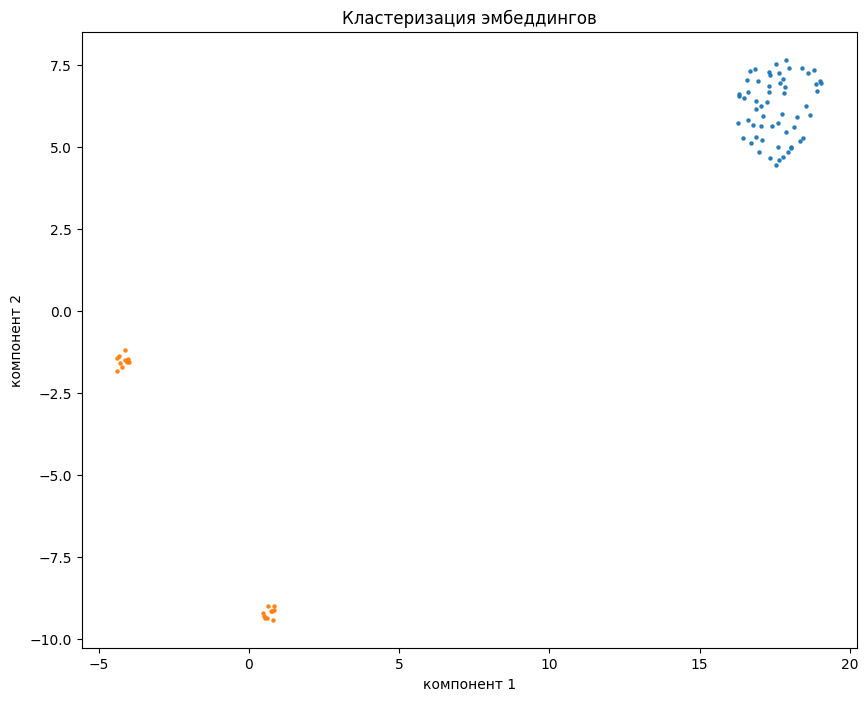

In [65]:
plt.figure(figsize=(10, 8))


unique_labels = list(set(labels))

for cluster_id in unique_labels:
    cluster_points = embeddings_2d[labels == cluster_id]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        s=5,
        alpha=0.9,
        label=f'Кластер {cluster_id}'
    )
# plt.legend()
plt.title('Кластеризация эмбеддингов')
plt.xlabel('компонент 1')
plt.ylabel('компонент 2')
plt.show()

In [66]:
import pandas as pd
df = pd.DataFrame({"labels": labels,
                  "artist": artist})


In [67]:
artist_stats = (
    df.groupby("artist")
      .agg(
          total_tracks=("labels", "count"),
          n_clusters=("labels", "nunique"),
      )
      .reset_index()
)

artist_stats[artist_stats["n_clusters"] >1]

,artist,total_tracks,n_clusters


In [1]:
# !pip install umap-learn
import numpy as np
from sklearn.cluster import KMeans
import polars as pl
import umap



/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Экспериментировать будем на самом активном пользователе. Получим его id и items_id

In [56]:
TIME_COL = "timestamp"  

# берем только последние 100 прослушиваний
items_of_most_popular_user = (
    pl.scan_parquet("../data/source/multi_event.parquet")
    .filter(pl.col("uid") == most_frequent_uid["uid"][0])
    .sort(TIME_COL, descending=True)
    .select("item_id")
    .limit(200)
    .collect()
    .to_series()
    .to_list()
)

embd_of_most_popular_user = (
    pl.scan_parquet("../data/source/filtered_embeddings.parquet")
    .filter(pl.col("item_id").is_in(items_of_most_popular_user))
    .collect()
)

embeddings = np.array(
    embd_of_most_popular_user["normalized_embed"].to_list(),
    dtype="float32"
)

np.random.seed(42)

print("UID:", most_frequent_uid["uid"][0])
print("ITEMS_ID:", items_of_most_popular_user[:10])
print("First embedding:", embeddings[0][:10])


UID: 997500
ITEMS_ID: [577185, 3061557, 6363059, 7894531, 6179825, 101445, 6101376, 8411535, 4888214, 568100]
First embedding: [ 0.03540228 -0.05485003  0.10024808  0.03810438 -0.21333185 -0.12746625
  0.05163249  0.01879922  0.08920899 -0.17306802]


Для кластеризации используется spherical mean Shift. Обычный k-means требует заранее задавать число кластеров, а угадать, сколько разных жанров пользователь слушал в последнее время, довольно сложно. DBSCAN хорошо работает со сложными формами кластеров, но в данном случае нам нужны именно плотные компактные группы векторов. Если пытаться учитывать сложные формы (что полезно для выделения глобальных жанров), то можно получить центры, лежащие слишком далеко или даже в «чужом» кластере.

Для визуализации будет использоваться UMAP, потому что этот метод хорошо сохраняет локальную структуру данных, масштабируется на большие наборы эмбеддингов, устойчив к шуму и позволяет наглядно отображать сложные многомерные кластеры в 2D или 3D-пространстве.

In [57]:
from utils import SphericalMeanShift, l2_normalize_rows, plot_clusters_3d_on_sphere

umap_model = umap.UMAP(
    n_neighbors=5,
    n_components=3,
    min_dist=0.0,
    metric="cosine",
)


clusterizer = SphericalMeanShift(  
    kappa=50.0,          
    max_iter=30,
    tol=1e-4 ,            
    merge_angle_deg=5.0)          


In [58]:
embeddings_3d = umap_model.fit_transform(embeddings)
true_dirs = l2_normalize_rows(embeddings_3d)

rng = np.random.default_rng(0)
labels, _ = clusterizer.fit_predict(embeddings_3d)

# Визуализация на сфере
plot_clusters_3d_on_sphere(true_dirs, labels, True, title="Spherical k-means on 3D sphere")

На графике крестиком показано, где бы приблизитльно был бы профильный вектор пользовтеля, если бы мы брали среднее по всем векторам. 
Наиболее оптимальным подходом будет сначала кластеризовать, брать по каждой группе свой вектор и уже отталкиваясь от него искать похожие песни 